In [1]:
import numpy as np
import matplotlib as pyplot
import scipy.linalg as la
import scipy.spatial as spat

In [2]:
class GlassInterpolator:
    def __init__ (self, x, y, F=None):
        self.x = x
        self.y = y
        self.L=x.shape[0]
        self.N=x.shape[1]
        
        if F is None:
            self.xn=np.copy(self.x)
        else:
            eva,eve=la.eig(F)
            self.eveT=eve.T
            self.sqrteva=np.sqrt(eva)
            self._getxn()
            
        self.delunay = None
        
    def _getxn(self):
        self.xn=np.array([np.dot(self.eveT,x)*self.sqrteva for x in self.x])
            
    def _interpolate(self,atxn,ndx, quadratic=False):
        x0=self.xn[ndx[0]]
        y0=self.y[ndx[0]]
        ndx=ndx[1:]
        ofs = np.array([self.xn[i]-x0 for i in ndx])
        yofs = np.array([self.y[i]-y0 for i in ndx])
        dx0=atxn-x0
        if quadratic:
            extra=np.array([ofs[:,i]*ofs[:,j] for i in range(self.N) for j in range(i, self.N)]).T
            ofs=np.hstack((ofs,extra))
            dx0=np.hstack((dx0, np.array([dx0[i]*dx0[j] for i in range(self.N) for j in range(i, self.N)])))
        if ofs.shape[0]==ofs.shape[1]:
            result=y0+np.einsum('ij,jk,i->k', la.inv(ofs), yofs,dx0)
        else:
            result=y0+np.einsum('ij,jk,i->k', la.pinv(ofs), yofs,dx0)
        return result

    def __call__(self,atx,kind='L'):
        ## first get closest neighbors
        if hasattr(self,"eveT"):
            atxn=np.dot(self.eveT,atx)*self.sqrteva
        else:
            atxn=np.copy(atx)
        ## kind can be N for nearest, L for linear, Q for quadratic, D for Delaunay, P for Pseudoinverse
        assert (kind in 'NLQDP')
        if kind in ['N','L','Q']:
            di=((self.xn-np.outer(np.ones(self.L),atxn))**2).sum(axis=1)
            ndx=np.argsort(di)
            ## now let's see how many we need in addition to the first one
            if kind=='N':
                result=self.y[ndx[0]]
            else:
                quadratic = kind=='Q'
                M=1+self.N + int(quadratic) * self.N*(self.N+1)//2
                result=self._interpolate(atxn,ndx[:M],quadratic)
        elif kind=='D' or kind=='P':
            if self.delunay is None:
                self.delunay = spat.Delaunay(self.xn)
            s=self.delunay.find_simplex(atxn)
            ndx=self.delunay.simplices[s]
            if kind=='D':
                result=self._interpolate(atxn,ndx)
            elif kind=='P':
                ## let's add twice more indices 
                di=((self.xn-np.outer(np.ones(self.L),atxn))**2).sum(axis=1)
                ndxmore=np.argsort(di)[:self.N+1]
                closest=ndxmore[0]               
                ndx=np.array([closest]+list(set(ndx)|set(ndxmore)-set([closest])))                
                result=self._interpolate(atxn,np.array(ndx))
                        
        return result
        
    

In [3]:
xar=np.linspace(0,2,100)
def testf(x):
    #return xar*x[0]-2*xar*x[1]+3*xar*x[2]-4*xar*x[3]*x[1]
    return np.cos(xar*x[0])+xar**2*x[1]*x[2]+2*np.exp(-xar**2/(2*x[3]))

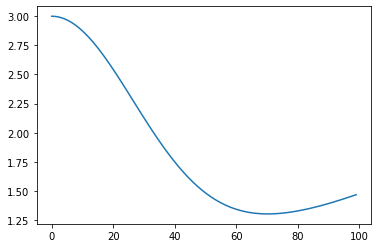

In [4]:
plt.plot(testf([0.3,0.2,0.8,0.3]))

In [5]:
T=10000
tx=np.random.uniform(0,1,4*T).reshape(T,4)
ty=np.array([testf(v) for v in tx])


In [6]:
V=GlassInterpolator(tx,ty)
atx=np.array([0.3,0.4,0.5,0.3])
true=testf(atx)
glassnear=V(atx,kind='N')
glasslin=V(atx,kind='L')
glassquad=V(atx,kind='Q')
glassdel=V(atx,kind='D')
glassps=V(atx,kind='P')

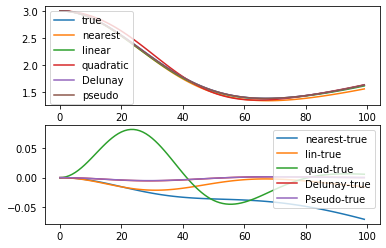

In [7]:
plt.subplot(2,1,1)
plt.plot(true,label='true')
plt.plot(glassnear,label='nearest')
plt.plot(glasslin,label='linear')
plt.plot(glassquad,label='quadratic')
plt.plot(glassdel,label='Delunay')
plt.plot(glassps,label='pseudo')
plt.legend()
plt.subplot(2,1,2)
plt.plot(glassnear-true,label='nearest-true')
plt.plot(glasslin-true,label='lin-true')
plt.plot(glassquad-true,label='quad-true')
plt.plot(glassdel-true,label='Delunay-true')
plt.plot(glassps-true,label='Pseudo-true')
plt.legend()

In [8]:
## test
C=4*np.outer([3/5,4/5],[3/5,4/5])+9*np.outer([-4/5,3/5],[-4/5,3/5])
eva,eve=la.eig(C)
print(eva,eve[:,0],eve[:,1])
ch=la.cholesky(C)
X=np.array([8,4])
for i in range(2):
    print (np.dot(X,eve[:,i])*np.sqrt(eva[i]))
print(np.dot(eve.T,X)*np.sqrt(eva))

[9.+0.j 4.+0.j] [ 0.8 -0.6] [0.6 0.8]
(11.999999999999998+0j)
(16+0j)
[12.+0.j 16.+0.j]


In [9]:
def test2(x):
    return np.cos(xar*(x[0]+3*x[1]))+1e-3*x[0] ##
## derivatives
def test2der(x):
    return -xar*np.sin(xar*(x[0]+3*x[1]))+1e-3,-3*xar*np.sin(xar*(x[0]+3*x[1]))
## Fisher=
d1=test2der([0.5,0.5])
F=np.array([[np.sum(d1[0]*d1[0]),np.sum(d1[0]*d1[1])],[np.sum(d1[0]*d1[1]),np.sum(d1[1]*d1[1])]])
print(la.eig(F)) ## one large and one small eigenvalue

(array([7.99800945e-05+0.j, 4.43371112e+02+0.j]), array([[-0.94873083, -0.31608515],
       [ 0.31608515, -0.94873083]]))


In [18]:
T=30
tx=np.random.uniform(0,1,2*T).reshape(T,2)
ty=np.array([test2(v) for v in tx])
V=GlassInterpolator(tx,ty)
V2=GlassInterpolator(tx,ty,F=np.array(F))
atx=np.array([0.5,0.5])
true=test2(atx)
glassps=V(atx,kind='P')
glassps2=V2(atx,kind='P')

/home/anze/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:581: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order='C', ndmin=1)
/home/anze/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


/home/anze/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


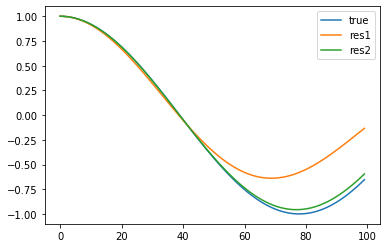

In [19]:
plt.plot(true,label='true')
plt.plot(glassps,label='res1')
plt.plot(glassps2,label='res2')
plt.legend()